In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'Fashion', 'VGG_7', 'Train1'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb

In [4]:
dataset, testset = loadDataset()

100%|██████████| 26421880/26421880 [00:00<00:00, 115231418.59it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6384799.76it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65543069.95it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22398627.59it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



###Library for random order

In [5]:
class SplitNN:
  def __init__(self, clients, server):
    self.clients = [c.cuda() for c in clients]
    self.server = server.cuda()

  def initialize(self, datasets, tester, epochs, batch, lr):
    for client, data in zip(self.clients, datasets):
      client.initialize(data, epochs, batch, lr)
    self.server.initialize(tester, epochs, lr)
    self.cached = [[] for c in self.clients]

  def evaluate(self):
    with torch.no_grad():
      self.server.eval()
      for client in self.clients:
        client.eval()
        client.accuracy.append(0)
        for images, labels in self.server.loader:
          output = self.server(client(images)).argmax(1)
          client.accuracy[-1] += (output == labels).sum().item()
        client.accuracy[-1] /= len(self.server.loader.dataset)

  def train_network(self, epoch, private=True, sequence=False, federate=False, caches=None, shuffle=False):
    local = lambda m, p: m.client[0] if p else m
    self.server.train()
    if shuffle:
      index = torch.randperm(len(self.clients))
    else: index = torch.arange(len(self.clients))
    clients = [self.clients[i] for i in index]
    if sequence: #SL
      model = local(clients[-1], private).state_dict()
    for idx, client in enumerate(clients):
      if caches: #Our
        index2 = index.tolist(); index2.remove(idx)
        cached = [self.cached[i] for i in index]
        maxlen = [caches[i] for i in index]
      if sequence: #SL
        local(client, private).load_state_dict(model)
      client.train()
      for images, labels in client.loader:
        client.zero_grad(), self.server.zero_grad()
        #output = self.server(client(images))
        output = client(images)
        #always cache data
        if len(labels) == batch:
          self.cached[idx] = (output.clone(), labels)
        else:
          self.cached[idx] = (torch.cat([self.cached[idx][0], output.clone()]),
                              torch.cat([self.cached[idx][1], labels]))
        if caches and epoch > 0:
          index3 = [torch.randperm(len(c)) for _,c in cached]
          images_cached = [c[0][i][:m] for c,i,m in zip(cached,index3,maxlen)]
          labels_cached = [c[1][i][:m] for c,i,m in zip(cached,index3,maxlen)]
          output = torch.cat([output] + images_cached)
          labels = torch.cat([labels] + labels_cached)
        output = self.server(output)
        loss = F.cross_entropy(output, labels)
        grads = self.server.backward(loss)
        client.backward(grads[:len(client.output)])
        #client.backward(self.server.backward(loss))
        client.optim_step(), self.server.optim_step()
      client.sched_step()
      if sequence: #SL
        model = local(client, private).state_dict()
    self.server.sched_step()
    if federate: #SFL
      models = [local(c, private).state_dict() for c in clients]
      for key in models[0]:
        for i in range(1, len(models)):
          models[0][key] += models[i][key]
        if models[0][key].type().split('.')[-1] == 'LongTensor':
          torch.div(models[0][key], len(models), rounding_mode='floor')
        else: models[0][key] /= len(models)
      for client in clients:
        local(client, private).load_state_dict(models[0])

In [6]:
def train_splitnn(clients, testset, method, epochs=epochs, model=Model, batch=batch, lr=lr, caches=None, shuffle=False):
  in_channels, num_classes, tester = loadTester(testset)
  models = [globals()[model](in_channels, num_classes) for c in clients]
  model = SplitNN([Client(m.client) for m in models], Server(models[0].server))
  model.initialize(clients, tester, epochs, batch, lr)

  for epoch in tqdm(range(epochs)):
    cache1 = caches if epoch>epochs/2 else None
    if method == 'private': model.train_network(epoch, private=True, sequence=False, federate=False, caches=cache1, shuffle=shuffle)
    #if method == 'sequence': model.train_network(epoch, private=False, sequence=True, federate=False, caches=caches, shuffle=shuffle)
    #if method == 'sequence_private': model.train_network(epoch, private=True, sequence=True, federate=False, caches=caches, shuffle=shuffle)
    #if method == 'federate': model.train_network(epoch, private=False, sequence=False, federate=True, caches=caches, shuffle=shuffle)
    #if method == 'federate_private': model.train_network(epoch, private=True, sequence=False, federate=True, caches=caches, shuffle=shuffle)
    model.evaluate()
    plot_progress(model.clients, locals())
  return model

#Non-IID

In [7]:
from torch.utils.data import Subset, ConcatDataset
datasets = [Subset(dataset, np.where(dataset.targets == c)[0]) for c in range(10)]
datasets = [ratio_split(s, [.3333333333333, .3333333333333, -1]) for s in datasets]
clients = [ConcatDataset([datasets[0].pop(), datasets[4].pop(), datasets[5].pop(), datasets[6].pop(), datasets[9].pop()]),
           ConcatDataset([datasets[0].pop(), datasets[1].pop(), datasets[5].pop(), datasets[6].pop(), datasets[7].pop()]),
           ConcatDataset([datasets[0].pop(), datasets[1].pop(), datasets[2].pop(), datasets[6].pop(), datasets[7].pop()]),
           ConcatDataset([datasets[1].pop(), datasets[2].pop(), datasets[3].pop(), datasets[7].pop(), datasets[8].pop()]),
           ConcatDataset([datasets[2].pop(), datasets[3].pop(), datasets[4].pop(), datasets[8].pop(), datasets[9].pop()]),
           ConcatDataset([datasets[3].pop(), datasets[4].pop(), datasets[5].pop(), datasets[8].pop(), datasets[9].pop()])]
#datasets

In [10]:
# private training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', shuffle=True).clients, '100-Prv-Rnd')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-100-Prv-Rnd.acc


In [12]:
# private training with caches
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', caches=caches).clients, '100-Prv-Cac')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-100-Prv-Cac.acc


In [ ]:
# private training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', shuffle=True).clients, '100-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

KeyboardInterrupt: ignored

In [ ]:
caches = [0 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 10, caches=caches, shuffle=False).clients, '100-Prv-Cac')

  0%|          | 0/10 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-100-Prv-Cac.acc


In [ ]:
caches = [1 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 50, caches=caches, shuffle=True).clients, '100-Prv-Cac')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-100-Prv-Cac.acc


In [ ]:
caches = [2 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 10, caches=caches, shuffle=False).clients, '100-Prv-Cac')

  0%|          | 0/10 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-100-Prv-Cac.acc


In [ ]:
# separated training
saveAccuracies(Gdrive, [m.clients[0] for m in train_separate(clients, (testset))], 'Non-Non')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

In [ ]:
# private training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private').clients, 'Non-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

In [ ]:
# sequential training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence').clients, 'Non-Seq')

0.6199
0.5933
0.6158
0.6152
0.6256
0.6089


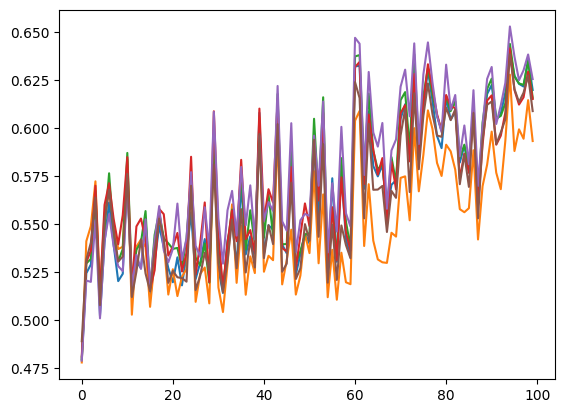

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Seq.acc')
for c in acc:
  plt.plot(c)
  print(c[-1])

In [ ]:
# federated training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'federate').clients, 'Non-Fed')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Fed.acc


In [ ]:
# private training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', caches=caches, shuffle=True).clients, 'Non-Prv-Cac')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Prv-Cac.acc


In [ ]:
# sequential training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence', caches=caches, shuffle=True).clients, 'Non-Seq-Cac')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Seq-Cac.acc


In [ ]:
# federated training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'federate', caches=caches, shuffle=True).clients, 'Non-Fed-Cac')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Fed-Cac.acc


#200 epochs

In [ ]:
# private training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 200).clients, 'Non-Prv')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Prv.acc


0.5850166666666666


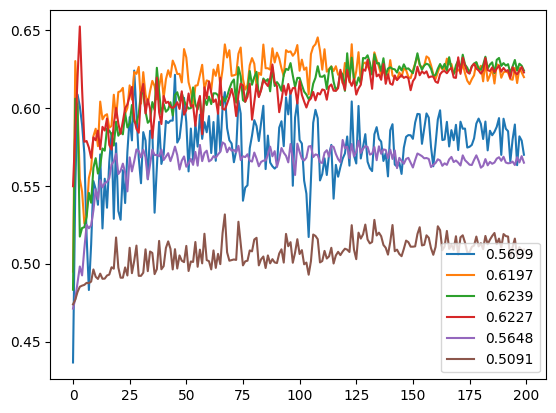

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Prv.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# private training randomly
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 200, shuffle=True).clients, 'Non-Prv-Rnd')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Prv-Rnd.acc


0.5457833333333334


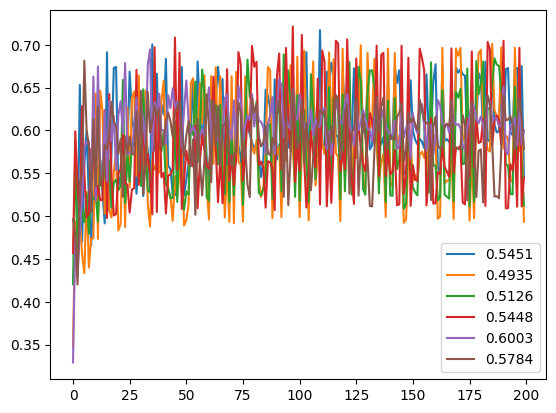

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Prv-Rnd.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# sequential training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence', 200).clients, 'Non-Seq')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Seq.acc


0.5743666666666667


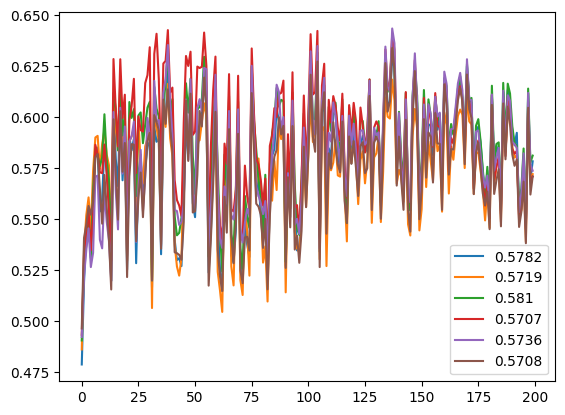

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Seq.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# sequential training randomly
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence', 200, shuffle=True).clients, 'Non-Seq-Rnd')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Seq-Rnd.acc


0.54045


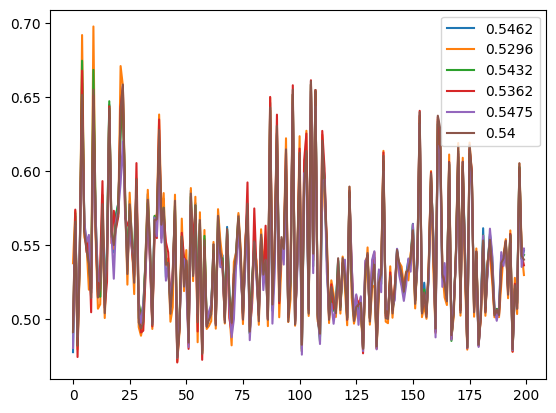

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Seq-Rnd.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# federated training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'federate', 200).clients, 'Non-Fed')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Fed.acc


0.65


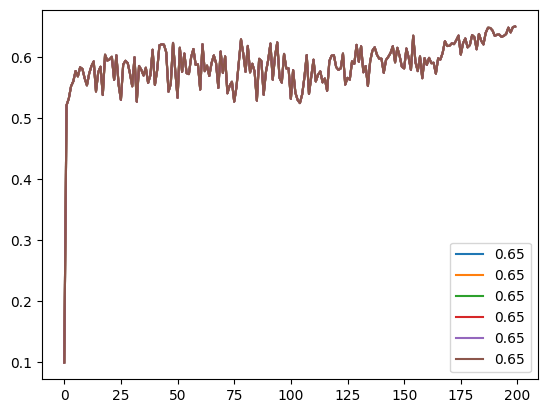

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Fed.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# federated training randomly
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'federate', 200, shuffle=True).clients, 'Non-Fed-Rnd')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Fed-Rnd.acc


0.582


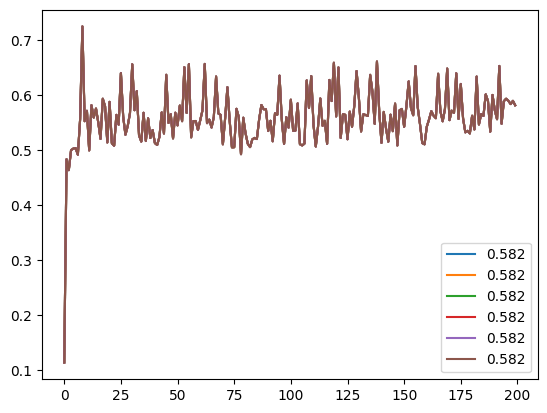

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Fed-Rnd.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# private training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 200, caches=caches, shuffle=True).clients, 'Non-Prv-Cac')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Prv-Cac.acc


0.4984166666666667


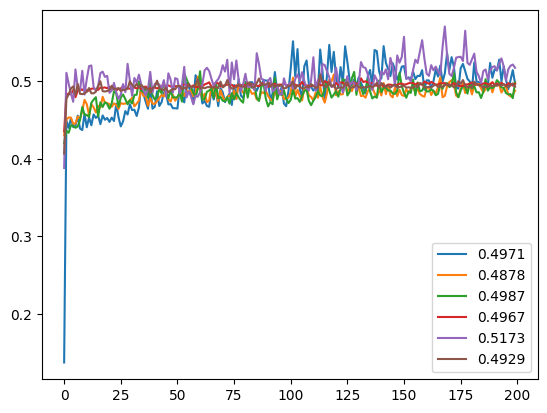

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Prv-Cac.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# sequential training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence', 200, caches=caches, shuffle=True).clients, 'Non-Seq-Cac')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Seq-Cac.acc


0.8912666666666667


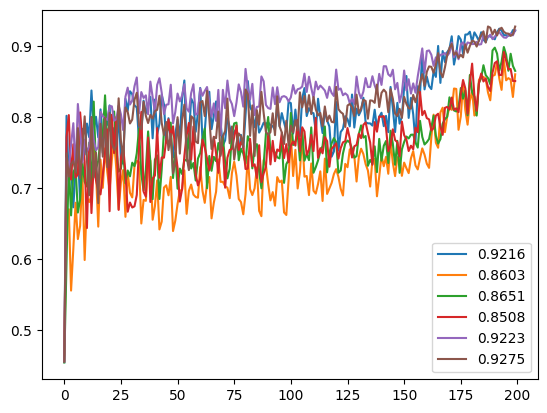

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Seq-Cac.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# federated training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'federate', 200, caches=caches, shuffle=True).clients, 'Non-Fed-Cac')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Fed-Cac.acc


0.9124


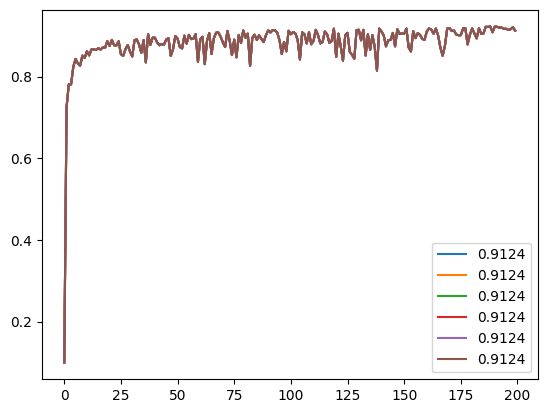

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Fed-Cac.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())

In [ ]:
# private training with cache
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', 200, caches=caches, shuffle=False).clients, 'Non-Prv-Cac-Rnd')

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/Fashion-VGG_7-Train1-6-Non-Prv-Cac-Rnd.acc


0.5108166666666667


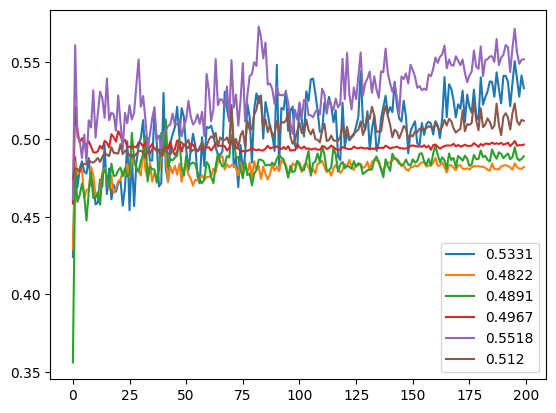

In [ ]:
acc = torch.load(Gdrive + '/data/Fashion-VGG_7-Train1-6-Non-Prv-Cac-Rnd.acc')
for c in acc: plt.plot(c, label=c[-1]); plt.legend()
print(np.array(acc)[:,-1].mean())